A corriger dans le process etl
- format datime : soit formart UTC soit format ns
- renommer les deux colonnes en df_transport = df_transport.rename(columns={'datetime_rounded': 'timestamp_rounded'})

In [159]:
import pandas as pd
import requests
import json
import os
import io
from dotenv import load_dotenv
import logging
from sqlalchemy import create_engine, text
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    f1_score,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

load_dotenv()

True

In [160]:
db_url = os.getenv("DATABASE_URL")

In [161]:
engine = create_engine(
    db_url,
    pool_pre_ping=True,
)

with engine.connect() as conn:
    result_transport = conn.execute(text("SELECT * FROM stg_transport_archive"))
    transport_data = result_transport.mappings().all()  # liste de dictionnaires

    result_weather = conn.execute(text("SELECT * FROM stg_weather_archive"))
    weather_data = result_weather.mappings().all()  # liste de dictionnaires

    

In [162]:
"""BASE_DIR = os.getcwd() 

DATA_DIR = os.path.join(BASE_DIR, "..","data")
json_path = os.path.join(DATA_DIR, "transport_koda_one_bus_3_days.json")
#json_path = os.path.join(DATA_DIR, "transport_koda_one_bus_any_days.json")

if not os.path.exists(json_path):
    print(f"Dossier actuel de recherche : {BASE_DIR}")
    raise FileNotFoundError(f"Le fichier {json_path} est introuvable.")

with open(json_path, 'r', encoding='utf-8') as f:
    transport_data = json.load(f)"""

'BASE_DIR = os.getcwd() \n\nDATA_DIR = os.path.join(BASE_DIR, "..","data")\njson_path = os.path.join(DATA_DIR, "transport_koda_one_bus_3_days.json")\n#json_path = os.path.join(DATA_DIR, "transport_koda_one_bus_any_days.json")\n\nif not os.path.exists(json_path):\n    print(f"Dossier actuel de recherche : {BASE_DIR}")\n    raise FileNotFoundError(f"Le fichier {json_path} est introuvable.")\n\nwith open(json_path, \'r\', encoding=\'utf-8\') as f:\n    transport_data = json.load(f)'

In [163]:
df_transport = pd.DataFrame(transport_data)
df_transport.describe()

,arrival_delay,departure_delay,direction_id,hour,id,stop_sequence,timestamp_rounded
count,1872.000000,1872.000000,1872.000000,1872.000000,1872.00000,1872.00000,1872
mean,76.741987,87.662927,0.500000,13.602564,3530.50000,18.50000,2025-03-03 16:50:46.153846272
min,-483.000000,-456.000000,0.000000,0.000000,2595.00000,1.00000,2025-01-05 23:00:00
25%,0.000000,0.000000,0.000000,9.000000,3062.75000,9.75000,2025-01-09 08:00:00
50%,62.500000,69.000000,0.500000,14.000000,3530.50000,18.50000,2025-03-10 11:30:00
75%,148.000000,157.000000,1.000000,18.000000,3998.25000,27.25000,2025-03-13 18:00:00
max,717.000000,717.000000,1.000000,23.000000,4466.00000,36.00000,2025-09-26 22:00:00
std,141.756052,138.062613,0.500134,5.631680,540.54417,10.39107,NaN


In [164]:
df_weather = pd.DataFrame(weather_data)
df_weather.sample(20)
df_weather.describe()

,cloud_cover,day_of_week,dew_point_2m,est_jour_ferie,est_weekend,month,neige_fondue,precipitation,rain,risque_gel_neige,...,snowfall,soleil_leve,temperature_2m,timestamp_rounded,vacances_scolaires,weather_code,wind_direction_10m,wind_gusts_10m,wind_speed_10m,year
count,8808.000000,8808.00000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,...,8808.000000,8808.000000,8808.000000,8808,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000
mean,65.123978,3.00000,4.444028,0.182561,0.283379,6.495913,0.009310,0.063669,0.057312,0.009764,...,0.004458,0.514986,8.281619,2025-07-03 11:30:00,0.305177,9.264192,211.479337,26.112920,11.708606,2025.005450
min,0.000000,0.00000,-15.900000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-14.300000,2025-01-01 00:00:00,0.000000,0.000000,0.000000,1.100000,0.000000,2025.000000
25%,18.000000,1.00000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.500000,2025-04-02 17:45:00,0.000000,0.000000,156.000000,16.900000,7.400000,2025.000000
50%,95.000000,3.00000,4.500000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,7.800000,2025-07-03 11:30:00,0.000000,3.000000,226.000000,24.500000,11.000000,2025.000000
75%,100.000000,5.00000,9.200000,0.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,14.300000,2025-10-03 05:15:00,1.000000,3.000000,278.000000,34.200000,15.500000,2025.000000
max,100.000000,6.00000,18.900000,1.000000,1.000000,12.000000,1.000000,8.400000,8.400000,1.000000,...,2.170000,1.000000,27.900000,2026-01-02 23:00:00,1.000000,75.000000,360.000000,91.400000,42.000000,2026.000000
std,41.391292,1.99329,6.711009,0.386328,0.450664,3.462624,0.096042,0.294477,0.286133,0.098334,...,0.049271,0.499804,7.585211,NaN,0.460509,18.712493,92.848273,12.278788,5.791210,0.073624


In [165]:
df_transport = pd.DataFrame(transport_data)

#df_transport = df_transport.rename(columns={'datetime_rounded': 'timestamp_rounded'})

# Pour vérifier
print(df_transport.columns)
df_transport.describe(include='all')

Index(['arrival_delay', 'bus_nbr', 'departure_delay', 'direction_id', 'hour',
       'id', 'stop_sequence', 'timestamp_rounded'],
      dtype='object')


,arrival_delay,bus_nbr,departure_delay,direction_id,hour,id,stop_sequence,timestamp_rounded
count,1872.000000,1872,1872.000000,1872.000000,1872.000000,1872.00000,1872.00000,1872
unique,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,541,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1872,NaN,NaN,NaN,NaN,NaN,NaN
mean,76.741987,NaN,87.662927,0.500000,13.602564,3530.50000,18.50000,2025-03-03 16:50:46.153846272
min,-483.000000,NaN,-456.000000,0.000000,0.000000,2595.00000,1.00000,2025-01-05 23:00:00
25%,0.000000,NaN,0.000000,0.000000,9.000000,3062.75000,9.75000,2025-01-09 08:00:00
50%,62.500000,NaN,69.000000,0.500000,14.000000,3530.50000,18.50000,2025-03-10 11:30:00
75%,148.000000,NaN,157.000000,1.000000,18.000000,3998.25000,27.25000,2025-03-13 18:00:00
max,717.000000,NaN,717.000000,1.000000,23.000000,4466.00000,36.00000,2025-09-26 22:00:00


In [166]:
# 1. Convertir en datetime ET forcer l'UTC pour les deux --> à corriger dans le process etl /!\
#df_transport['timestamp_rounded'] = pd.to_datetime(df_transport['timestamp_rounded'], utc=True)
#df_weather['timestamp_rounded'] = pd.to_datetime(df_weather['timestamp_rounded'], utc=True)

# 2. Maintenant le merge fonctionnera sans erreur
df_merged = pd.merge(
    df_transport,
    df_weather,
    on="timestamp_rounded",
    how="left"
)

# 3. Suppression des colonnes
cols_to_drop = ["id", "observation_uuid", "entity_id", "route_id_static", "timestamp", "timestamp_dt", 
                "trip_id", "route_id", "year", "uv_index", "shortwave_radiation"]

df_merged = df_merged.drop(columns=cols_to_drop, errors='ignore')

df_merged.sample(20)

,arrival_delay,bus_nbr,departure_delay,direction_id,hour,stop_sequence,timestamp_rounded,cloud_cover,day_of_week,dew_point_2m,...,risque_gel_neige,risque_gel_pluie,snowfall,soleil_leve,temperature_2m,vacances_scolaires,weather_code,wind_direction_10m,wind_gusts_10m,wind_speed_10m
572,55,541,64,0,21,4,2025-03-12 21:00:00,100,2,-3.7,...,1,0,0.21,0,-0.8,0,73,41,22.3,9.3
1264,13,541,22,1,7,12,2025-01-07 07:00:00,100,1,0.6,...,0,0,0.00,0,2.8,1,3,215,38.2,16.2
825,117,541,130,1,17,21,2025-03-14 17:00:00,64,4,-8.4,...,0,0,0.00,1,2.2,0,2,326,22.3,5.4
118,281,541,289,0,15,14,2025-03-09 15:00:00,44,6,3.2,...,0,0,0.00,1,8.6,0,1,191,24.8,10.4
1242,213,541,219,1,12,25,2025-01-07 12:00:00,100,1,-0.1,...,0,0,0.00,1,2.6,1,3,184,38.9,20.4
1717,83,541,92,0,18,9,2025-01-12 18:00:00,2,6,-9.6,...,0,0,0.00,0,-7.4,0,0,282,17.3,8.8
112,86,541,97,1,11,11,2025-03-09 11:00:00,96,6,3.8,...,0,0,0.00,1,8.1,0,3,180,22.0,8.8
1226,328,541,358,0,12,20,2025-01-07 12:00:00,100,1,-0.1,...,0,0,0.00,1,2.6,1,3,184,38.9,20.4
1006,-120,541,126,0,22,1,2025-03-15 22:00:00,99,5,-3.0,...,0,0,0.00,0,1.5,0,3,252,39.2,18.2
1112,44,541,60,1,6,1,2025-01-06 06:00:00,100,0,-8.2,...,0,0,0.00,0,-7.5,1,3,99,13.7,6.6


In [167]:
df_merged.columns

Index(['arrival_delay', 'bus_nbr', 'departure_delay', 'direction_id', 'hour',
       'stop_sequence', 'timestamp_rounded', 'cloud_cover', 'day_of_week',
       'dew_point_2m', 'est_jour_ferie', 'est_weekend', 'month',
       'neige_fondue', 'precipitation', 'rain', 'risque_gel_neige',
       'risque_gel_pluie', 'snowfall', 'soleil_leve', 'temperature_2m',
       'vacances_scolaires', 'weather_code', 'wind_direction_10m',
       'wind_gusts_10m', 'wind_speed_10m'],
      dtype='object')

# EDA

In [168]:
# ====================
# 1. CHARGEMENT ET NETTOYAGE
# ====================

# Filtrer les données avec transport
df = df_merged[df_merged['departure_delay'].notna()].copy()

print("="*20)
print("EXPLORATION DES DONNÉES - JUSTIFICATION MÉTHODOLOGIQUE")
print("="*20)
print(f"\nNombre total d'observations : {len(df):,}")
print(f"Période couverte : {df['timestamp_rounded'].min()} à {df['timestamp_rounded'].max()}")
print(f"Nombre de jours : {df['timestamp_rounded'].dt.date.nunique()}")

EXPLORATION DES DONNÉES - JUSTIFICATION MÉTHODOLOGIQUE

Nombre total d'observations : 1,872
Période couverte : 2025-01-05 23:00:00 à 2025-09-26 22:00:00
Nombre de jours : 17



1. DISTRIBUTION DES RETARDS

Statistiques des retards (en secondes) :
count    1872.000000
mean       87.662927
std       138.062613
min      -456.000000
25%         0.000000
50%        69.000000
75%       157.000000
max       717.000000
Name: departure_delay, dtype: float64

Médiane : 69.0s
Mode : 0.0s

Répartition par tranches de retard :
delay_category
Avance      515
0-1 min     363
1-2 min     358
2-5 min     496
5-10 min    134
>10 min       6
Name: count, dtype: int64

En pourcentage :
delay_category
Avance      27.5
0-1 min     19.4
1-2 min     19.1
2-5 min     26.5
5-10 min     7.2
>10 min      0.3
Name: proportion, dtype: float64


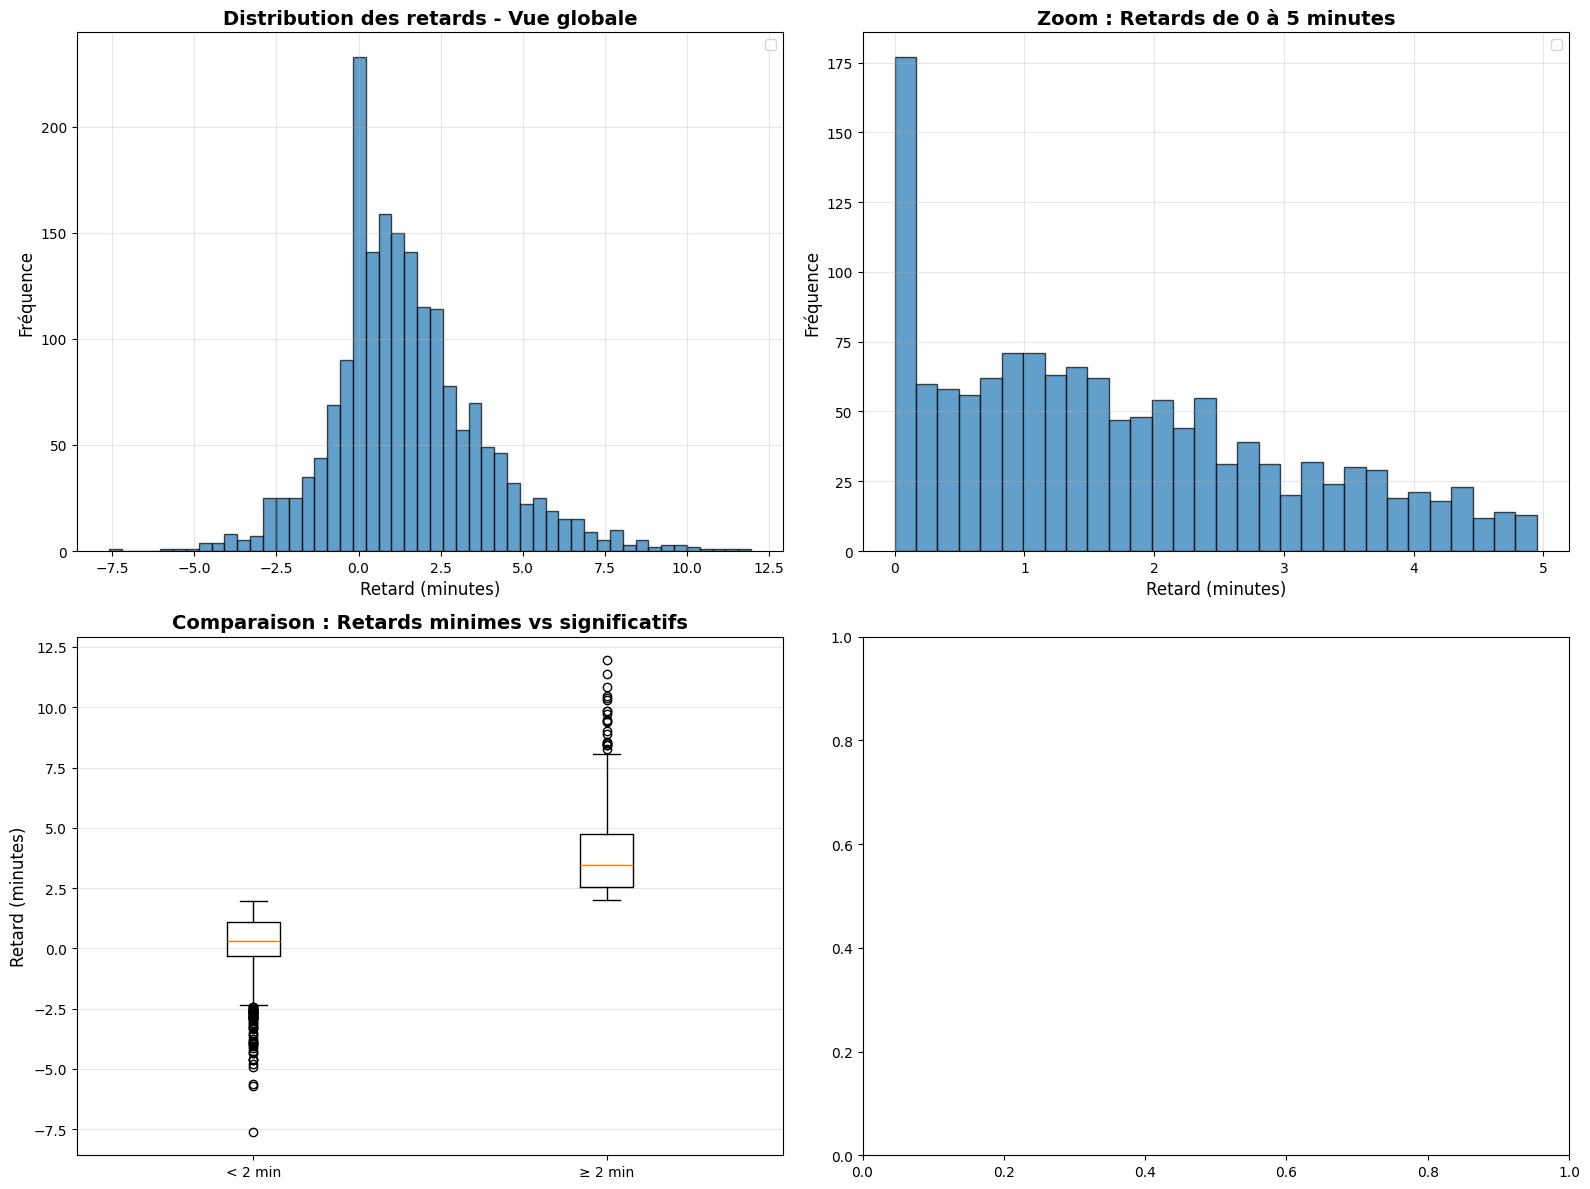

In [169]:
# ====================
# 2. DISTRIBUTION DES RETARDS - ARGUMENT CLÉ
# ====================

print("\n" + "="*20)
print("1. DISTRIBUTION DES RETARDS")
print("="*20)

# Statistiques descriptives
print("\nStatistiques des retards (en secondes) :")
print(df['departure_delay'].describe())
print(f"\nMédiane : {df['departure_delay'].median():.1f}s")
print(f"Mode : {df['departure_delay'].mode().values[0]:.1f}s")

# Conversion en minutes pour lisibilité
df['delay_minutes'] = df['departure_delay'] / 60

# Distribution détaillée par tranches
print("\nRépartition par tranches de retard :")
bins = [-500, 0, 60, 120, 300, 600, 3000]
labels = ['Avance', '0-1 min', '1-2 min', '2-5 min', '5-10 min', '>10 min']
df['delay_category'] = pd.cut(df['departure_delay'], bins=bins, labels=labels)
print(df['delay_category'].value_counts().sort_index())
print("\nEn pourcentage :")
print((df['delay_category'].value_counts(normalize=True)*100).sort_index().round(1))

# GRAPHIQUE 1 : Distribution bimodale
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogramme global
axes[0, 0].hist(df['delay_minutes'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Retard (minutes)', fontsize=12)
axes[0, 0].set_ylabel('Fréquence', fontsize=12)
axes[0, 0].set_title('Distribution des retards - Vue globale', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Focus sur les petits retards (0-5 min)
mask_small = (df['delay_minutes'] >= 0) & (df['delay_minutes'] <= 5)
axes[0, 1].hist(df.loc[mask_small, 'delay_minutes'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Retard (minutes)', fontsize=12)
axes[0, 1].set_ylabel('Fréquence', fontsize=12)
axes[0, 1].set_title('Zoom : Retards de 0 à 5 minutes', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Boxplot par catégories
df_boxplot = df[df['delay_minutes'] <= 20]  # Limiter pour visibilité
axes[1, 0].boxplot([df_boxplot[df_boxplot['delay_minutes'] < 2]['delay_minutes'],
                     df_boxplot[df_boxplot['delay_minutes'] >= 2]['delay_minutes']],
                    labels=['< 2 min', '≥ 2 min'])
axes[1, 0].set_ylabel('Retard (minutes)', fontsize=12)
axes[1, 0].set_title('Comparaison : Retards minimes vs significatifs', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

plt.tight_layout()

On pourrait considérer 2 populations :
- retards minimes vs significatifs
- 68 % des cas, moins de 2 min de rtards (quasi à l'heure)
- 32 % avec plus de 2 min de retards (retards réel)


3. CORRÉLATIONS DIFFÉRENTES SELON LE GROUPE

 Corrélations avec departure_delay :
                Sans_retard_significatif  Avec_retard_significatif  Différence
temperature_2m                    -0.009                     0.043       0.052
precipitation                      0.042                    -0.016      -0.058
wind_speed_10m                     0.013                    -0.036      -0.049
cloud_cover                       -0.010                     0.032       0.042
stop_sequence                     -0.393                     0.047       0.440
hour                               0.064                     0.111       0.047


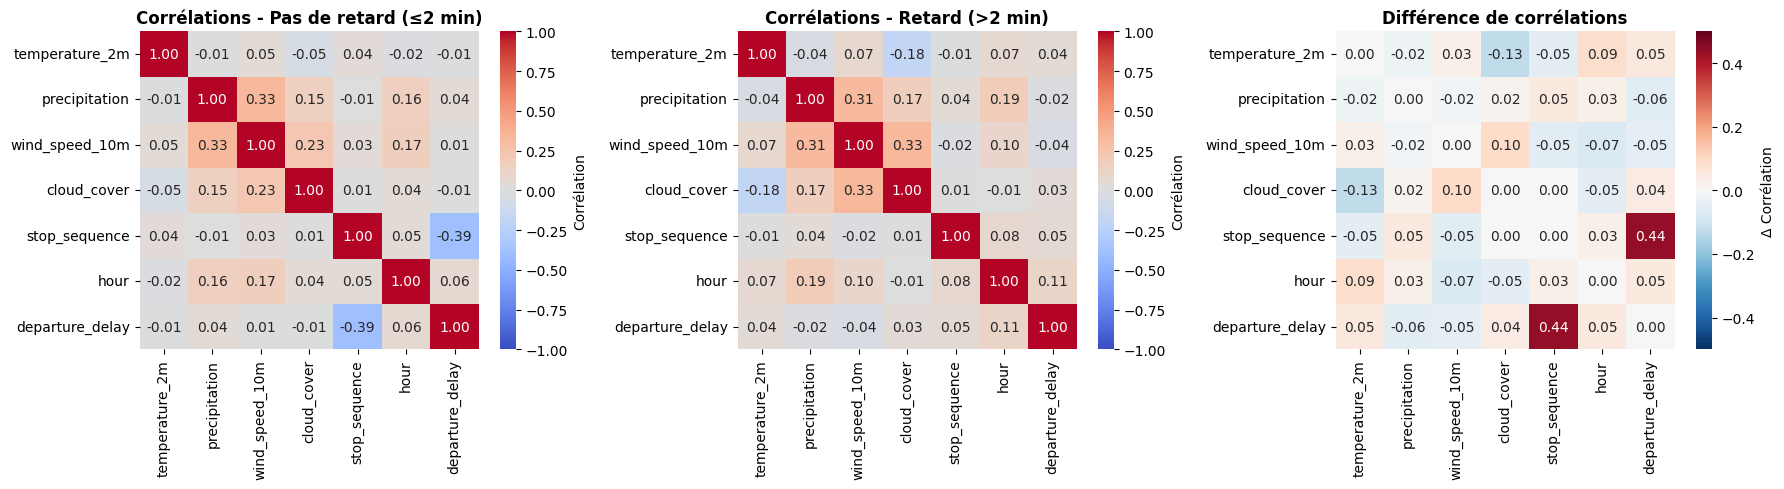

In [170]:
# ============================================================================
# 3. CORRÉLATIONS CONDITIONNELLES
# ============================================================================

print("\n" + "="*20)
print("3. CORRÉLATIONS DIFFÉRENTES SELON LE GROUPE")
print("="*20)

SEUIL = 120  # 2 minutes
df['has_delay'] = (df['departure_delay'] > SEUIL).astype(int)

# Calculer corrélations pour chaque groupe
numeric_cols = ['temperature_2m', 'precipitation', 'wind_speed_10m', 
                'cloud_cover', 'stop_sequence', 'hour']

df_no_delay = df[df['has_delay']==0][numeric_cols + ['departure_delay']].copy()
df_delay = df[df['has_delay']==1][numeric_cols + ['departure_delay']].copy()

corr_no_delay = df_no_delay.corr()['departure_delay'].drop('departure_delay')
corr_delay = df_delay.corr()['departure_delay'].drop('departure_delay')

print("\n Corrélations avec departure_delay :")
corr_comparison = pd.DataFrame({
    'Sans_retard_significatif': corr_no_delay,
    'Avec_retard_significatif': corr_delay,
    'Différence': corr_delay - corr_no_delay
})
print(corr_comparison.round(3))

# GRAPHIQUE 3 : Heatmap comparative
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Sans retard
sns.heatmap(df_no_delay.corr(), annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, ax=axes[0], cbar_kws={'label': 'Corrélation'})
axes[0].set_title('Corrélations - Pas de retard (≤2 min)', fontsize=12, fontweight='bold')

# Avec retard
sns.heatmap(df_delay.corr(), annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, ax=axes[1], cbar_kws={'label': 'Corrélation'})
axes[1].set_title('Corrélations - Retard (>2 min)', fontsize=12, fontweight='bold')

# Différence
diff_matrix = df_delay.corr() - df_no_delay.corr()
sns.heatmap(diff_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, vmin=-0.5, vmax=0.5, ax=axes[2], cbar_kws={'label': 'Δ Corrélation'})
axes[2].set_title('Différence de corrélations', fontsize=12, fontweight='bold')

plt.tight_layout()

Facteurs explicatifs différents
* Les corrélations changent selon le groupe retards +/- 2 min



4. PATTERNS TEMPORELS - Justification de features temporelles

Retards par heure de la journée :
    hour  prob_retard  retard_moyen
0      0         0.52        118.19
1      1         0.11         25.67
2      3         0.00         66.00
3      4         0.22         72.26
4      5         0.16         40.47
5      6         0.22         57.26
6      7         0.19         37.06
7      8         0.27         68.97
8      9         0.26         52.31
9     10         0.24         41.77
10    11         0.36         87.40
11    12         0.36         87.96
12    13         0.35         84.78
13    14         0.30         76.69
14    15         0.43        114.98
15    16         0.49        129.97
16    17         0.37         86.90
17    18         0.49        136.45
18    19         0.45        135.26
19    20         0.40        105.44
20    21         0.25         87.99
21    22         0.40        103.20
22    23         0.34         88.40


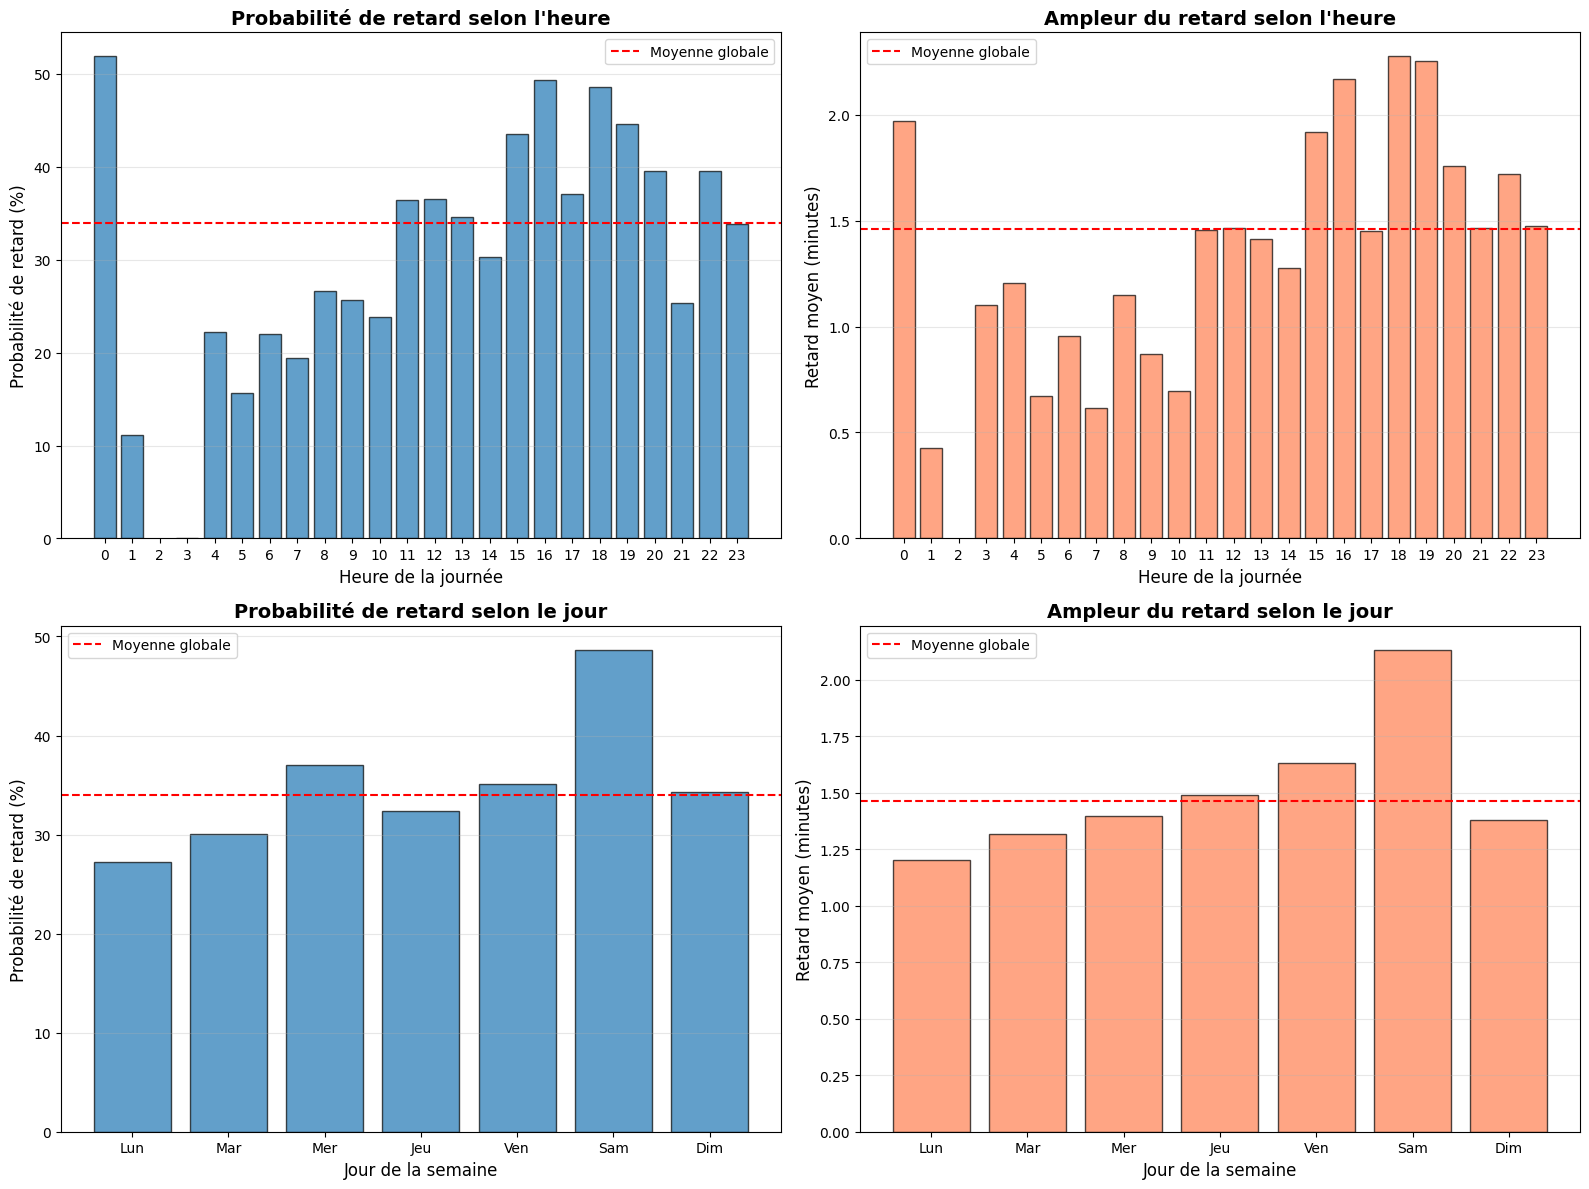

In [171]:
# =====================
# 5. PATTERNS TEMPORELS
# =====================

print("\n" + "="*20)
print("4. PATTERNS TEMPORELS - Justification de features temporelles")
print("="*20)

# Par heure
delay_by_hour = df.groupby('hour').agg({
    'has_delay': 'mean',
    'departure_delay': 'mean'
}).reset_index()
delay_by_hour.columns = ['hour', 'prob_retard', 'retard_moyen']

print("\nRetards par heure de la journée :")
print(delay_by_hour.round(2))

# Par jour de la semaine
delay_by_dow = df.groupby('day_of_week').agg({
    'has_delay': 'mean',
    'departure_delay': 'mean'
}).reset_index()
delay_by_dow.columns = ['day_of_week', 'prob_retard', 'retard_moyen']
delay_by_dow['day_name'] = delay_by_dow['day_of_week'].map({
    0: 'Lun', 1: 'Mar', 2: 'Mer', 3: 'Jeu', 4: 'Ven', 5: 'Sam', 6: 'Dim'
})

# GRAPHIQUE 4 : Patterns temporels
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1- Probabilité de retard par heure
axes[0, 0].bar(delay_by_hour['hour'], delay_by_hour['prob_retard']*100, 
               edgecolor='black', alpha=0.7)
axes[0, 0].axhline(df['has_delay'].mean()*100, color='red', linestyle='--', 
                   label='Moyenne globale')
axes[0, 0].set_xlabel('Heure de la journée', fontsize=12)
axes[0, 0].set_ylabel('Probabilité de retard (%)', fontsize=12)
axes[0, 0].set_title('Probabilité de retard selon l\'heure', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_xticks(range(24))

# 2- Ampleur moyenne par heure
axes[0, 1].bar(delay_by_hour['hour'], delay_by_hour['retard_moyen']/60, 
               color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].axhline(df['departure_delay'].mean()/60, color='red', linestyle='--', 
                   label='Moyenne globale')
axes[0, 1].set_xlabel('Heure de la journée', fontsize=12)
axes[0, 1].set_ylabel('Retard moyen (minutes)', fontsize=12)
axes[0, 1].set_title('Ampleur du retard selon l\'heure', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_xticks(range(24))

# 3- Par jour de la semaine - Probabilité
axes[1, 0].bar(delay_by_dow['day_name'], delay_by_dow['prob_retard']*100, 
               edgecolor='black', alpha=0.7)
axes[1, 0].axhline(df['has_delay'].mean()*100, color='red', linestyle='--', 
                   label='Moyenne globale')
axes[1, 0].set_xlabel('Jour de la semaine', fontsize=12)
axes[1, 0].set_ylabel('Probabilité de retard (%)', fontsize=12)
axes[1, 0].set_title('Probabilité de retard selon le jour', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4- Par jour de la semaine - Ampleur
axes[1, 1].bar(delay_by_dow['day_name'], delay_by_dow['retard_moyen']/60, 
               color='coral', edgecolor='black', alpha=0.7)
axes[1, 1].axhline(df['departure_delay'].mean()/60, color='red', linestyle='--', 
                   label='Moyenne globale')
axes[1, 1].set_xlabel('Jour de la semaine', fontsize=12)
axes[1, 1].set_ylabel('Retard moyen (minutes)', fontsize=12)
axes[1, 1].set_title('Ampleur du retard selon le jour', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()


5. IMPACT MÉTÉO - Différent selon qu'il y a retard ou non

 Retards selon les conditions météo :
              Nombre  Prob_retard  Retard_moyen_sec  Retard_moyen_min
weather_code                                                         
Bruine            71         0.44            103.70          1.728333
Ciel clair       395         0.32             81.03          1.350500
Neige            158         0.38             99.56          1.659333
Nuageux         1248         0.33             87.34          1.455667


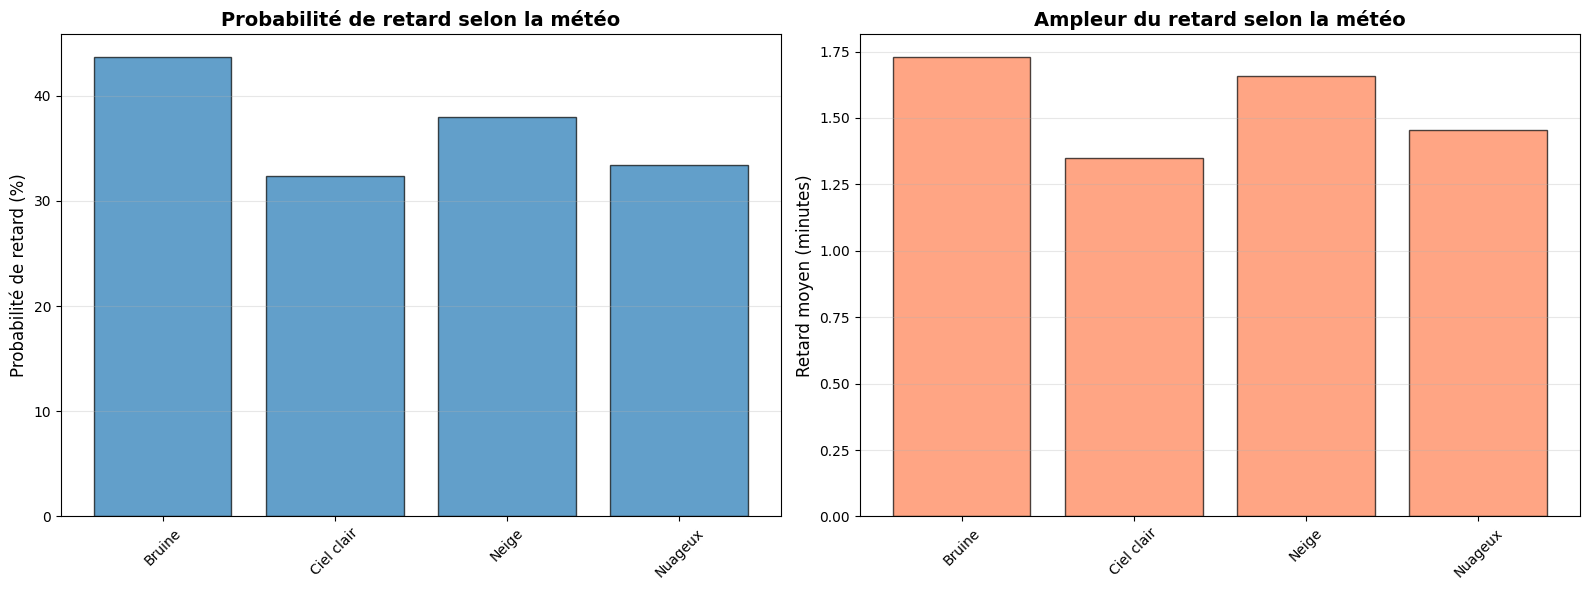

In [172]:
# ========================================
# 6. IMPACT MÉTÉO - VISION CONDITIONNELLE
# =======================================

print("\n" + "="*20)
print("5. IMPACT MÉTÉO - Différent selon qu'il y a retard ou non")
print("="*20)

# Catégoriser la météo
df.loc[df['weather_code'].isin([61, 63, 65]), 'weather_code'] = 'Pluie'
df.loc[df['weather_code'].isin([71, 73, 75]), 'weather_code'] = 'Neige'
df.loc[df['weather_code'].isin([51, 53, 55]), 'weather_code'] = 'Bruine'
df.loc[df['weather_code'].isin([1, 2, 3]), 'weather_code'] = 'Nuageux'
df.loc[df['weather_code'].isin([0]), 'weather_code'] = 'Ciel clair'

print("\n Retards selon les conditions météo :")
meteo_impact = df.groupby('weather_code').agg({
    'has_delay': ['count', 'mean'],
    'departure_delay': 'mean'
}).round(2)

meteo_impact.columns = ['Nombre', 'Prob_retard', 'Retard_moyen_sec']
meteo_impact['Retard_moyen_min'] = meteo_impact['Retard_moyen_sec'] / 60
print(meteo_impact)

# GRAPHIQUE 5 : Impact météo
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

meteo_stats = df.groupby('weather_code').agg({
    'has_delay': 'mean',
    'departure_delay': 'mean'
}).reset_index()

axes[0].bar(meteo_stats['weather_code'], meteo_stats['has_delay']*100, 
            edgecolor='black', alpha=0.7)
axes[0].set_ylabel('Probabilité de retard (%)', fontsize=12)
axes[0].set_title('Probabilité de retard selon la météo', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(meteo_stats['weather_code'], meteo_stats['departure_delay']/60, 
            color='coral', edgecolor='black', alpha=0.7)
axes[1].set_ylabel('Retard moyen (minutes)', fontsize=12)
axes[1].set_title('Ampleur du retard selon la météo', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()

In [173]:
# Statistiques finales
print("\n Statistiques finales :")
print(f"  Nombre total d'observations : {len(df):}")
print(f"  Retard moyen global : {df['departure_delay'].mean()/60:.2f} minutes")
print(f"  Retard moyen si retard >2 min : {df[df['has_delay']==1]['departure_delay'].mean()/60:.2f} minutes")
print(f"  Écart-type global : {df['departure_delay'].std()/60:.2f} minutes")
print(f"  Écart-type si retard >2 min : {df[df['has_delay']==1]['departure_delay'].std()/60:.2f} minutes")

print("\n" + "="*20)
print("EXPLORATION TERMINÉE")
print("="*20)


 Statistiques finales :
  Nombre total d'observations : 1872
  Retard moyen global : 1.46 minutes
  Retard moyen si retard >2 min : 3.93 minutes
  Écart-type global : 2.30 minutes
  Écart-type si retard >2 min : 1.76 minutes

EXPLORATION TERMINÉE


## Synthèse 

On pourrait considérer 2 populations :
- retards minimes vs significatifs
- 68 % des cas, moins de 2 min de rtards (quasi à l'heure)
- 32 % avec plus de 2 min de retards (retards réel)

Facteurs explicatifs différents
* Les corrélations changent selon le groupe retards +/- 2 min
* Probabilité de retard vs ampleur du retard différentes

Objectifs différents
* 1/ doit je prévenir l'usager d'un retard ? --> 0/1
* 2/ de combien sera le retard ? --> indication précise
--> prédire 2 min quand il n'y a pas de retard == est-ce utile ??

L'idée
- 1 modèle unique = risque de mélanger deux phénomènes différents
- Regression seule = force à prédire des micro-variations non pertinentes
- deux modèles optimisés : chacun sa tâche

--> Etape 1 : Classfier (retard oui/non avec seuil à 2min)
--> Etape 2 : Si retard prédit, estimer l'ampleur (régression sur uniquement les cas de retards)

# ML

In [174]:
# ====================
# PRÉPARATION DES DONNÉES
# ====================
# Filtrer uniquement les lignes où on a des données de transport
df = df_merged[df_merged['departure_delay'].notna()].copy()

print(f"Nombre total d'observations : {len(df)}")
print(f"Retards > 2 min : {(df['departure_delay'] > 120).sum()} ({(df['departure_delay'] > 120).mean()*100:.1f}%)")

Nombre total d'observations : 1872
Retards > 2 min : 636 (34.0%)


In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1872 entries, 0 to 1871
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   arrival_delay       1872 non-null   int64         
 1   bus_nbr             1872 non-null   object        
 2   departure_delay     1872 non-null   int64         
 3   direction_id        1872 non-null   int64         
 4   hour                1872 non-null   int64         
 5   stop_sequence       1872 non-null   int64         
 6   timestamp_rounded   1872 non-null   datetime64[ns]
 7   cloud_cover         1872 non-null   int64         
 8   day_of_week         1872 non-null   int64         
 9   dew_point_2m        1872 non-null   float64       
 10  est_jour_ferie      1872 non-null   int64         
 11  est_weekend         1872 non-null   int64         
 12  month               1872 non-null   int64         
 13  neige_fondue        1872 non-null   int64       

In [176]:
# ====================
# FEATURE ENGINEERING
# ====================

# Définir le seuil de retard (2 minutes = 120 secondes)
SEUIL_RETARD = 120
df['is_delayed'] = (df['departure_delay'] > SEUIL_RETARD).astype(int)

# Features temporelles additionnelles
#df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)

# Sélection des features
feature_cols = [
    # Transport
    'direction_id', 'stop_sequence', 'hour', 
    # Temporel
    'day_of_week', 'est_weekend', 'est_jour_ferie', 'vacances_scolaires',
    'is_rush_hour', 'soleil_leve', 'month',
    # Météo brute
    'temperature_2m', 'precipitation', 'wind_speed_10m', 'cloud_cover',
    'snowfall', 'rain', 'weather_code', 'dew_point_2m', 'wind_direction_10m', 'wind_gusts_10m',
    # Risques
    'risque_gel_neige', 'risque_gel_pluie', 'neige_fondue'
]

# Garder seulement les colonnes existantes
feature_cols = [col for col in feature_cols if col in df.columns]

# Séparer features numériques et catégorielles
numeric_features = df[feature_cols].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df[feature_cols].select_dtypes(include=['object']).columns.tolist()

print(f"\nFeatures numériques : {len(numeric_features)}")
print(f"Features catégorielles : {len(categorical_features)}")


Features numériques : 22
Features catégorielles : 0


In [177]:
# ====================
# PRÉPARATION X ET Y
# ====================

X = df[feature_cols].copy()
y_classification = df['is_delayed']


# Split train/test
X_train, X_test, y_class_train, y_class_test = train_test_split(
    X, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

print(f"Train : {X_train.shape[0]} samples ({y_class_train.sum()} retards)")
print(f"Test  : {X_test.shape[0]} samples ({y_class_test.sum()} retards)")

# ====================
# PIPELINE DE PRÉTRAITEMENT
# ====================

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

Train : 1497 samples (509 retards)
Test  : 375 samples (127 retards)



 Entraînement des modèles...

Entraînement LogisticRegression...
F1-Score : 0.5148
Recall   : 0.8898
Precision: 0.3622
Seuil optimal: 0.36

Entraînement RandomForest...
F1-Score : 0.5523
Recall   : 0.7480
Precision: 0.4378
Seuil optimal: 0.25

Entraînement XGBoost...
F1-Score : 0.5390
Recall   : 0.6535
Precision: 0.4586
Seuil optimal: 0.25

RÉSULTATS FINAUX SUR TEST SET
            Modèle  F1-Score   Recall  Precision  Seuil
      RandomForest  0.552326 0.748031   0.437788   0.25
           XGBoost  0.538961 0.653543   0.458564   0.25
LogisticRegression  0.514806 0.889764   0.362179   0.36


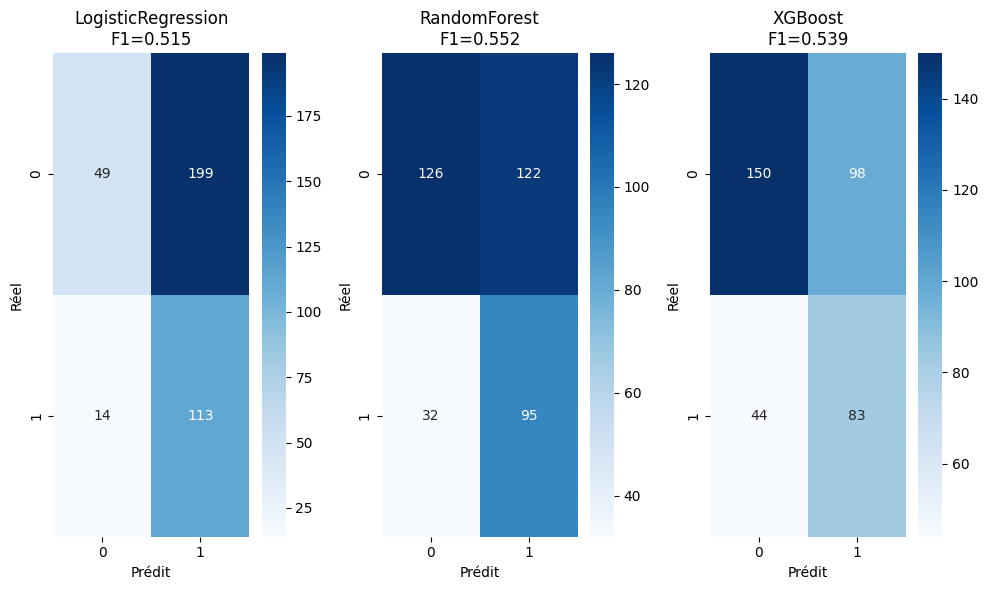


ENTRAÎNEMENT TERMINÉ - Scores HONNÊTES et FIABLES !

Visualisation de l'importance des features...


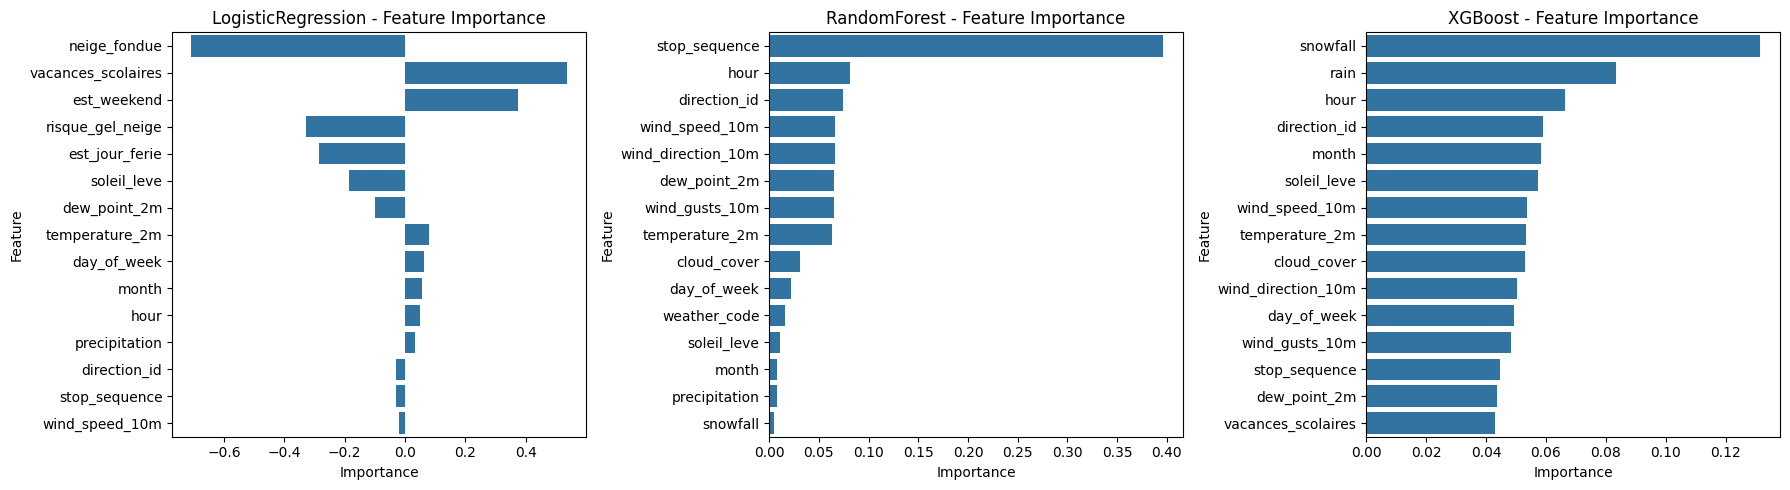

In [178]:
# =====================================================
# ENTRAÎNEMENT ET ÉVALUATION
# =====================================================
print("\n Entraînement des modèles...")

models = {
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
}

results = {}

for name, model in models.items():
    print(f"\nEntraînement {name}...")
    
    # ENTRAÎNEMENT SUR DONNÉES RESAMPLED
    model.fit(X_train, y_class_train)
    
    # ÉVALUATION SUR TEST SET (données JAMAIS vues)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Recherche du meilleur seuil
    best_f1 = 0
    best_threshold = 0.5
    for threshold in np.arange(0.1, 0.9, 0.01):
        y_pred_thresh = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_class_test, y_pred_thresh)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    # Prédiction finale avec le meilleur seuil
    y_pred_final = (y_pred_proba >= best_threshold).astype(int)
    
    results[name] = {
        'f1': f1_score(y_class_test, y_pred_final),
        'recall': recall_score(y_class_test, y_pred_final),
        'precision': precision_score(y_class_test, y_pred_final),
        'threshold': best_threshold,
        'cm': confusion_matrix(y_class_test, y_pred_final)
    }
    
    print(f"F1-Score : {results[name]['f1']:.4f}")
    print(f"Recall   : {results[name]['recall']:.4f}")
    print(f"Precision: {results[name]['precision']:.4f}")
    print(f"Seuil optimal: {best_threshold:.2f}")

# =====================================================
# AFFICHAGE RÉSULTATS
# =====================================================
print("\n" + "="*60)
print("RÉSULTATS FINAUX SUR TEST SET")
print("="*60)

results_df = pd.DataFrame({
    'Modèle': list(results.keys()),
    'F1-Score': [results[m]['f1'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Seuil': [results[m]['threshold'] for m in results.keys()]
}).sort_values('F1-Score', ascending=False)

print(results_df.to_string(index=False))

# =====================================================
# VISUALISATION MATRICES DE CONFUSION
# =====================================================
fig, axes = plt.subplots(1, 3, figsize=(10, 6))

for idx, (name, res) in enumerate(results.items()):
    cm = res['cm']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f"{name}\nF1={res['f1']:.3f}")
    axes[idx].set_xlabel("Prédit")
    axes[idx].set_ylabel("Réel")

plt.tight_layout()
plt.show()

print("\nENTRAÎNEMENT TERMINÉ - Scores HONNÊTES et FIABLES !")
print("="*60)

# =====================================================
# VISUALISATION FEATURE IMPORTANCE (CORRIGÉE)
# =====================================================

print("\nVisualisation de l'importance des features...")

importances = {}

for name, model in models.items():

    if name == "LogisticRegression":
        df_imp = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": model.coef_[0]
        })

    elif name == "RandomForest":
        df_imp = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": model.feature_importances_
        })

    elif name == "XGBoost":
        df_imp = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": model.feature_importances_
        })

    else:
        continue

    # On trie par importance absolue (important pour Logistic)
    df_imp["AbsImportance"] = df_imp["Importance"].abs()
    df_imp = df_imp.sort_values("AbsImportance", ascending=False).head(15)

    importances[name] = df_imp


# =====================
# AFFICHAGE GRAPHIQUE
# =====================

plt.figure(figsize=(18, 5))

for i, (name, df_imp) in enumerate(importances.items(), 1):
    plt.subplot(1, 3, i)
    sns.barplot(
        x="Importance",
        y="Feature",
        data=df_imp,
        orient="h"
    )
    plt.title(f"{name} - Feature Importance")

plt.tight_layout()
plt.show()


In [ ]:
# relancer le modèle xgboost avec recherche des hyperparamètres

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# =====================================================
# RÉGRESSION — UNIQUEMENT SUR LES RETARDS
# =====================================================

df_reg = df[df["is_delayed"] == 1].copy()

X_reg = df_reg[feature_cols]
y_reg = df_reg["departure_delay"]

print(f"Nombre de trajets en retard : {len(df_reg)}")
print(f"Retard moyen : {y_reg.mean():.2f} secondes")

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

reg_models = {
    "Ridge": Ridge(alpha=1.0),
    
    "RandomForest": RandomForestRegressor(
        n_estimators=500,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ),
    
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    )
}

reg_results = {}

for name, regressor in reg_models.items():
    print(f"\nEntraînement {name}...")

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", regressor)
    ])

    pipeline.fit(X_reg_train, y_reg_train)

    y_pred = pipeline.predict(X_reg_test)

    reg_results[name] = {
        "MAE_sec": mean_absolute_error(y_reg_test, y_pred),
        "RMSE_sec": np.sqrt(mean_squared_error(y_reg_test, y_pred)),
        "R2": r2_score(y_reg_test, y_pred)
    }

    print(f"MAE  : {reg_results[name]['MAE_sec']:.2f} sec")
    print(f"RMSE : {reg_results[name]['RMSE_sec']:.2f} sec")
    print(f"R²   : {reg_results[name]['R2']:.3f}")

reg_results_df = pd.DataFrame(reg_results).T
reg_results_df["MAE_min"] = reg_results_df["MAE_sec"] / 60

print("\nRÉCAPITULATIF RÉGRESSION")
print("="*50)
print(reg_results_df.sort_values("R2", ascending=False))


"""
reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=500,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ))
])

print(\nEntraînement RandomForestRegressor...)

reg_pipeline.fit(X_reg_train, y_reg_train)

y_pred_reg = reg_pipeline.predict(X_reg_test)

mae = mean_absolute_error(y_reg_test, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg))
r2 = r2_score(y_reg_test, y_pred_reg)

print(\n=== RÉSULTATS RÉGRESSION (retards uniquement) ===)
print(f"MAE  : {mae:.2f} sec ({mae/60:.2f} min)")
print(f"RMSE : {rmse:.2f} sec")
print(f"R²   : {r2:.3f}")
"""

Nombre de trajets en retard : 636
Retard moyen : 235.70 secondes

Entraînement Ridge...
MAE  : 74.46 sec
RMSE : 93.87 sec
R²   : 0.002

Entraînement RandomForest...
MAE  : 72.39 sec
RMSE : 92.28 sec
R²   : 0.035

Entraînement GradientBoosting...
MAE  : 73.53 sec
RMSE : 96.86 sec
R²   : -0.063

RÉCAPITULATIF RÉGRESSION
                    MAE_sec   RMSE_sec        R2   MAE_min
RandomForest      72.386006  92.275486  0.035495  1.206433
Ridge             74.461576  93.871758  0.001837  1.241026
GradientBoosting  73.533051  96.862062 -0.062770  1.225551


'reg_pipeline = Pipeline(steps=[\n    ("preprocessor", preprocessor),\n    ("regressor", RandomForestRegressor(\n        n_estimators=500,\n        min_samples_leaf=5,\n        random_state=42,\n        n_jobs=-1\n    ))\n])\n\nprint("\nEntraînement RandomForestRegressor...")\n\nreg_pipeline.fit(X_reg_train, y_reg_train)\n\ny_pred_reg = reg_pipeline.predict(X_reg_test)\n\nmae = mean_absolute_error(y_reg_test, y_pred_reg)\nrmse = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg))\nr2 = r2_score(y_reg_test, y_pred_reg)\n\nprint("\n=== RÉSULTATS RÉGRESSION (retards uniquement) ===")\nprint(f"MAE  : {mae:.2f} sec ({mae/60:.2f} min)")\nprint(f"RMSE : {rmse:.2f} sec")\nprint(f"R²   : {r2:.3f}")\n'

In [181]:
# ====================
# PRÉDICTION EN DEUX ÉTAPES
# ====================

print("\n" + "="*20)
print("EXEMPLE D'UTILISATION - Prédiction en 2 étapes")
print("="*20)

def predict_delay(model_clf, model_reg, X_new):
    """
    Prédit d'abord s'il y aura un retard, puis son ampleur
    """
    # Étape 1 : Classification
    proba_delay = model_clf.predict_proba(X_new)[:, 1]
    has_delay = model_clf.predict(X_new)
    
    # Étape 2 : Régression (seulement si retard prédit)
    delay_amount = np.zeros(len(X_new))
    mask_delayed = has_delay == 1
    
    if mask_delayed.sum() > 0:
        delay_amount[mask_delayed] = model_reg.predict(X_new[mask_delayed])
    
    return has_delay, proba_delay, delay_amount

# Test sur quelques exemples
sample_indices = np.random.choice(len(X_test), 5, replace=False)
X_sample = X_test.iloc[sample_indices]

has_delay, proba, amount = predict_delay(clf_rf, reg_rf, X_sample)

print("\nExemples de prédictions :")
for i, idx in enumerate(sample_indices):
    print(f"\nObservation {i+1}:")
    print(f"  Probabilité de retard : {proba[i]*100:.1f}%")
    if has_delay[i]:
        print(f"  Retard prédit : {amount[i]/60:.1f} minutes")
    else:
        print(f"  Pas de retard prévu")
    print(f"  Retard réel : {y_reg_test.iloc[idx]/60:.1f} minutes")

print("\n" + "="*20)
print("ANALYSE TERMINÉE")
print("="*20)


EXEMPLE D'UTILISATION - Prédiction en 2 étapes

Exemples de prédictions :

Observation 1:
  Probabilité de retard : 9.9%
  Pas de retard prévu


IndexError: single positional indexer is out-of-bounds